# TDC 102: Data Functions

[Kexin](https://twitter.com/KexinHuang5)

Welcome to the TDC community! In this tutorial, we will cover the basics of TDC data functions and after this tutorial, you will be able to leverage most of the useful functions supported!

We assume you have familiarize yourself with the installations and data loaders. If not, please visit [TDC 101 Data Loaders](https://github.com/mims-harvard/TDC/blob/master/tutorials/TDC_101_Data_Loader.ipynb) first!

First, we introduce data splits. The data spliting function splits data into training, validation and test set for machine learning practitioners to train, tune and evaluate their models. This function is called directly on the data loader class. It mainly takes in the following three inputs:

* `method` the spliting scheme. TDC provides various spliting schemes to reflect realistic evaluations (details in section below). Default is random split.

* `seed` the random seed. TDC has a benchmark seed for fair comparison, which is set in default.

* `frac` the fraction of train/validation/test set, in default, it is set to be [0.7, 0.1, 0.2].

As the default TDC data format is Pandas DataFrame, it will return a dictionary with key 'train', 'valid', and 'test' and value of each set's data frame.


In [1]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')
split = data.get_split(method = 'random')
split['test'].head(2)

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,VLA-4 antagonist 3,S1CN(S(=O)(=O)c2cn(nc2)C)[C@H](C(=O)N[C@@H](Cc...,-5.17
1,Astilbin,O1[C@@H](C)[C@H](O)[C@@H](O)[C@@H](O)[C@@H]1O[...,-6.82


TDC also provides two realistic splits. First is for compound property prediction task, which is based on the scaffold of the molecules so that train/val/test set is more structurally different. Note that scaffold split requires RDKit package. You can find the installation instruction [here](https://www.rdkit.org/docs/Install.html). For example, to do scaffold split on Caco2 data, you can do:

In [2]:
split = data.get_split(method = 'scaffold')
split['test'].head(2)

100%|██████████| 910/910 [00:00<00:00, 1029.21it/s]


,Drug_ID,Drug,Y
0,PNU-184421,Fc1cc(N2C[C@@H](OC2=O)CNC(=O)C)ccc1-c1ccc(nc1)C#N,-4.378375
1,PNU-184470,S=C(NC[C@@H]1OC(=O)N(C1)c1cc(F)c(N2CCCS(=O)(=O...,-4.639136


In addition to scaffold split, we also include a cold-start split for multi-instance prediction problem such as DTI, GDA, DrugRes, MTI, where they present two entity types. It first splits on one entity type into train/valid/test and then move all pairs associated with that entity in each set as the final splits. To do that, first set `column_name` to be the entity you want to split on. For example, to do cold drug split on DTI prediction task:

In [3]:
from tdc.multi_pred import DTI
data = DTI(name = 'DAVIS')
split = data.get_split(method = 'cold_split', column_name = 'Drug')

Found local copy...
Loading...
Done!


Then, we talk about several ways to do label manipulation. As an example, we load the Caco2 data from ADME in single instance preediction task:

In [4]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang')

Found local copy...
Loading...
Done!


You can visualize the label distribution by typing:

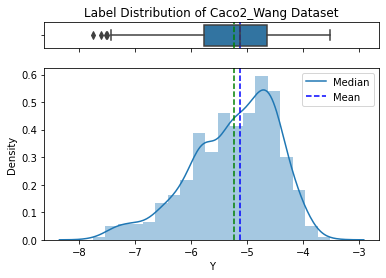

In [5]:
data.label_distribution()

You can also binarize the data if you want to do binary classification instead. For example, for Caco-2, we know higher than -4.7 is good, so we can do binarization by typing:

Binariztion using threshold -4.7, default, we assume the smaller values are 1 and larger ones is 0, you can change the order by 'binarize(order = 'ascending')'


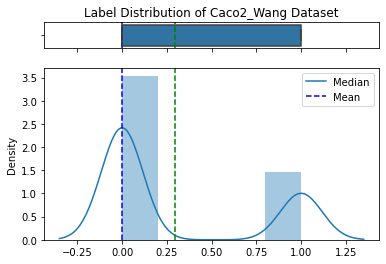

In [6]:
data.binarize(threshold = -4.7, order = 'ascending')
data.label_distribution()

Now, we see that it transforms to binary data. We can also see the size between positive and negative classes. 

TDC also supports data balancing. For example, for high-throughput screening data, the majority of data are negative samples and using this highly imbalanced data would cause the ML training unstable. 

We use SARSCoV2 3CL Protease screening to illustrate. First, let's load it:

Found local copy...
Loading...
Done!


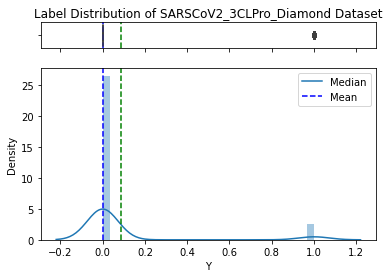

In [7]:
from tdc.single_pred import HTS
data = HTS(name = 'SARSCoV2_3CLPro_Diamond')
data.label_distribution()

We see the data is very imbalanced. To balance the data via oversampling the positive class, you can do:

In [8]:
data_df = data.balanced(oversample = True, seed = 42)

 Oversample of minority class is used. 


Note that since data balancing adds/removes data points, we create a separate pandas data frame to keep the original data loader class intact. To visualize the label distribution for an array of labels by using a utility function:

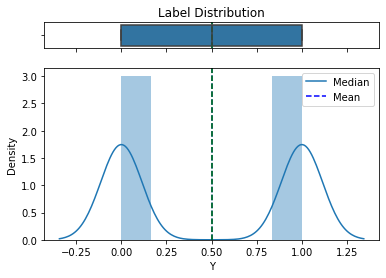

In [9]:
from tdc import utils
utils.label_dist(data_df.Y)

For datasets with binding affinity with unit nM, we also provide label unit conversion since the standard ML practice is to transform it into unit p for easier regression:

In [10]:
from tdc.multi_pred import DTI
data = DTI(name = 'DAVIS')
data.convert_to_log()

Found local copy...
Loading...
Done!
To log space...


For some datasets with relational labels, you can get the meaning of the labels, using:

In [11]:
from tdc.multi_pred import DDI
from tdc.utils import get_label_map
data = DDI(name = 'DrugBank')
get_label_map(name = 'DrugBank', task = 'DDI')[1]

Found local copy...
Loading...
Done!


'#Drug1 may increase the photosensitizing activities of #Drug2.'

For interactions between two entities such as drug-target interactions, some users may want to formulate it as a network prediction task instead of chemical modeling. We also provide a function to transform the pair tabular data to graph edge list. For example, to construct a graph for DTI DAVIS dataset with threshold 30, split set to true, fraction 70%/10%/20%, benchmark seed, and descending order:

In [12]:
from tdc.multi_pred import DTI
data = DTI(name = 'DAVIS')

Found local copy...
Loading...
Done!


In [13]:
graph = data.to_graph(threshold = 30, 
                      format = 'edge_list', 
                      split = True, 
                      frac = [0.7, 0.1, 0.2], 
                      seed = 42, 
                      order = 'descending')
graph.keys()

The dataset label consists of affinity scores. Binarization using threshold 30 is conducted to construct the positive edges in the network. Adjust the threshold by to_graph(threshold = X)


dict_keys(['edge_list', 'neg_edges', 'split'])

TDC also provides transformation to popular Graph ML library such as DGL/Pytorch Geometric, although these two packages are required in order to be used:

In [14]:
graph = data.to_graph(threshold = 30, format = 'dgl', split = True, frac = [0.7, 0.1, 0.2], seed = 42, order = 'descending')
graph.keys()

The dataset label consists of affinity scores. Binarization using threshold 30 is conducted to construct the positive edges in the network. Adjust the threshold by to_graph(threshold = X)
Using backend: pytorch


dict_keys(['dgl_graph', 'index_to_entities', 'split'])

In [15]:
graph = data.to_graph(threshold = 30, format = 'pyg', split = True, frac = [0.7, 0.1, 0.2], seed = 42, order = 'descending')
graph.keys()

The dataset label consists of affinity scores. Binarization using threshold 30 is conducted to construct the positive edges in the network. Adjust the threshold by to_graph(threshold = X)


dict_keys(['pyg_graph', 'index_to_entities', 'split'])

For some interaction datasets, there are only positive samples provided. In order to do binary classification, we have to construct negative samples. One popular way is to consider the unobserved as negative samples. This is usually the case for biomedical data as a hit has way smaller chance than being negative. For some dataset with pairwise experimental assay (e.g. HuRI), sample from the unobserved pair are also true negatives. We use HuRI as an example:

In [16]:
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')
data.neg_sample(frac = 1)

Found local copy...
Loading...
Done!


You can also adjust the negative sample fraction to reflect the realistic ratios between positive and negative by simply tuning the `frac` parameter.

Next, we also provide two functions for database queries to retrieve features for drugs and protein/gene. For drug, the default feature for many ML model is the SMILES string, and for protein, it is the amino acid sequence. You can get the SMILES string from a PubChem CID with: 

In [17]:
from tdc.utils import cid2smiles
cid2smiles(2248631)

'CCOC1=CC(=C(C=C1C=CC(=O)O)Br)OCC'

You can get the amino acid sequence from the Uniprot ID via:

In [18]:
from tdc.utils import uniprot2seq
uniprot2seq('P49122')

'MKTLLLTLVVVTIVCLDLGYTLKCHNTQLPFIYNTCPEGKNLCFKATLKFPLKFPVKRGCAATCPRSSSLVKVVCCKTDKCN'

## Evaluator

In addition to these data processing helpers, TDC also includes evaluators for the various therapeutics tasks. We include two kinds of Evaluators here. First is to evaluate the prediction accuracy. The second is to evaluate the quality of the molecules generated by distribution learning. All of the metrics are included in the website page [here](https://zitniklab.hms.harvard.edu/TDC/functions/data_evaluation/). 

First, we show the examples that evaluate the prediction accuracy. It includes 

* `Precision`

* `Recall`

* `F1` score is the harmonic mean of the precision and recall.

* `ROC-AUC` (Area Under the Receiver Operating Characteristic Curve). ROC curve summarize the trade-off between the true positive rate and false positive rate for a predictive model using different probability thresholds.

* `PR-AUC` (Precision-Recall Area Under Curve). Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.


* `Accuracy` computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels. 

* `MSE` (Mean Squared Error) of an estimator measures the average of the squares of the errors. 

* `MAE` (Mean Absolute Error) is a measure of absolute errors between paired observations. 

* `r2` is regression score function.

* `macro-f1` assess the quality of problems with multiple binary labels or multiple classes. Macro F1-score will give the same importance to each label/class. It will be low for models that only perform well on the common classes while performing poorly on the rare classes.

* `micro-f1` assess the quality of multi-label binary problems. It measures the F1-score of the aggregated contributions of all classes. Micro-averaging will put more emphasis on the common labels in the data set since it gives each sample the same importance.



For instance, given a list/array of binary true values `y_true` and a list/array of real-valued predicted scores `y_pred`, you want to generate the PR-AUC:

In [19]:
y_true = [0, 1, 1, 0, 1]
y_pred = [0.2, 0.2, 0.2, 0.8, 0.89]

from tdc import Evaluator
evaluator = Evaluator(name = 'ROC-AUC')
evaluator(y_true, y_pred)

evaluator2 = Evaluator(name = 'PR-AUC')
evaluator2(y_true, y_pred)

0.7333333333333334

Then, we show the second one, the evaluators that evaluate the quality of the molecules generated by distribution learning.

It includes 

* `Validity` is the percentage of the valid molecules in the whole generated molecules. Some SMILES can not be transformed into realistic molecules due to syntactic error. 

* `Novelty` is the percentage of the canonical SMILES that are not in the training set of molecule generation. 

* `Diversity` 

* `Uniqueness` is the percentage of different canonical SMILES in the whole generated molecules. 

* `fcd_distance` (Frechet ChemNet Distance) is a measure of how close distributions of generated molecules are to the distribution of molecules in the training set. 

* `kl_divergence` KL divergence measures the distance between two probability distribution. Then the probability distributions of a series of physicochemical descriptors for the training set and generated molecules are compared. 


Assume we have a batch of molecules:

In [20]:
smiles_lst = ['CC(C)(C)[C@H]1CCc2c(sc(NC(=O)COc3ccc(Cl)cc3)c2C(N)=O)C1', \
              'C[C@@H]1CCc2c(sc(NC(=O)c3ccco3)c2C(N)=O)C1', \
              'CCNC(=O)c1ccc(NC(=O)N2CC[C@H](C)[C@H](O)C2)c(C)c1', \
              'C[C@@H]1CCN(C(=O)CCCc2ccccc2)C[C@@H]1O']

Validity function will screen all the molecules and check the fraction of chemical validity of the set:

In [21]:
validity = Evaluator(name = 'validity')
print(validity(smiles_lst))

1.0


Novelty measures the fraction of molecules that are different from training set. Low novelty means the models is overfitted. Here we use the same list of molecules to illustrate. Thus, as they are the same, the novelty should be 0.

In [22]:
novelty = Evaluator(name = 'novelty')

In [23]:
print(novelty(generated_smiles_lst = smiles_lst, training_smiles_lst = smiles_lst))

0.0


Diversity measures the internal distance among the generated molecules. Low diversity means all molecules in the set are pretty similar, which means that the generation does not generate meaningful molecules, i.e., mode collapse.

In [24]:
diversity = Evaluator(name = 'diversity')

In [25]:
print(diversity(smiles_lst))

0.2454994457536287


Uniqueness is another metric that can detect mode collapse. This function measures the the fraction of unique molecules in a generated moelcule pool.

In [26]:
unique = Evaluator(name = 'uniqueness')

In [27]:
print(unique(smiles_lst + smiles_lst + smiles_lst))

0.3333333333333333


KL-divergence directly measures deviation between two distributions. 

In [28]:
kl_divergence = Evaluator(name = 'KL_Divergence')

In [29]:
print(kl_divergence(generated_smiles_lst = smiles_lst, training_smiles_lst = smiles_lst))

1.0


FCD distance (Fréchet ChemNet Distance) is a measure of distance between two distribution based on activations of the penultimate layer of a neural network, ChemNet that trained to predict biological activities of drugs. Note FCD correlates with other metrics. For example, if the generated structures are not diverse enough or the model produces too many duplicates, FCD will decrease, since the variance is smaller. Values of this metric are non-negative, lower is better.

In [30]:
fcd = Evaluator(name = 'fcd_distance')

In [31]:
print(fcd(generated_smiles_lst = smiles_lst, training_smiles_lst = smiles_lst))

Instructions for updating:
Please use Model.predict, which supports generators.
1.0000051849132214


That's most of the currently supported data functions! For molecular generation oracles, we provide a separate tutorials (TDC 105) to do that.

**Please [contact us](mailto:kexinhuang@hsph.harvard.edu) if you want to contribute to include useful data functions!**

In the next set of tutorials, we are going to cover 

* [TDC 103 Part 1: Datasets - Small Molecules](https://github.com/mims-harvard/TDC/blob/master/tutorials/TDC_103.1_Datasets_Small_Molecules.ipynb)

* [TDC 103 Part 2: Datasets - Biologics](https://github.com/mims-harvard/TDC/blob/master/tutorials/TDC_103.2_Datasets_Biologics.ipynb)

* [TDC 104 ML Model Examples with DeepPurpose](https://github.com/mims-harvard/TDC/blob/master/tutorials/TDC_104_ML_Model_DeepPurpose.ipynb)

* [TDC 105 Molecular Oracles](https://github.com/mims-harvard/TDC/blob/master/tutorials/TDC_105_Oracles.ipynb)

Check them out!